# HPC 6.1 Data Wrangling and Processing for Genomics

A lot of genomics analysis is done using command-line tools for three reasons: 

* you will often be working with a large number of files, and working through the command-line rather than through a graphical user interface (GUI) allows you to automate repetitive tasks, 
* you will often need more compute power than is available on your personal computer, and connecting to and interacting with remote computers requires a command-line interface, and 
* you will often need to customise your analyses, and command-line tools often enable more customisation than the corresponding GUI tools (if in fact a GUI tool even exists).

## Installing some tools

We are going to install a number of command line tools we'll use for this **pipeline**. You might be familiar with some of them and we'll explain exactly what they do later.

There are a number of ways we can do this, here we'll use the **Ubuntu Linux** `apt install` tool but later on ARC we'll do this in a different way.

In [ ]:
!apt install -qq fastqc \
trimmomatic \
bwa \
samtools \
bcftools

## Lets confirm these tools work

We will run each one at the command line to confirm it is installed properly.

In [ ]:
! fastqc -h

In [ ]:
!TrimmomaticPE

In [ ]:
!bwa

In [ ]:
!samtools

In [ ]:
!bcftools

## Downloading data

We now need to create a folder to download to, change directory into it and grab the files we are foing to use.

This is going to take a few minutes so set it going and we can read ahead and find out more about the workflow.

In [ ]:
!mkdir -p /content/data/untrimmed_fastq/

In [ ]:
!ls -l

In [ ]:
%cd /content/data/untrimmed_fastq/

In [ ]:
!curl -O ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR258/004/SRR2589044/SRR2589044_1.fastq.gz
!curl -O ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR258/004/SRR2589044/SRR2589044_2.fastq.gz
!curl -O ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR258/003/SRR2584863/SRR2584863_1.fastq.gz
!curl -O ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR258/003/SRR2584863/SRR2584863_2.fastq.gz
!curl -O ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR258/006/SRR2584866/SRR2584866_1.fastq.gz
!curl -O ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR258/006/SRR2584866/SRR2584866_2.fastq.gz 

## Building a workflow

When working with high-throughput sequencing data, the raw reads you get off of the sequencer will need to pass through a number of different tools in order to generate your final desired output. The execution of this set of tools in a specified order is commonly referred to as a workflow or a pipeline.


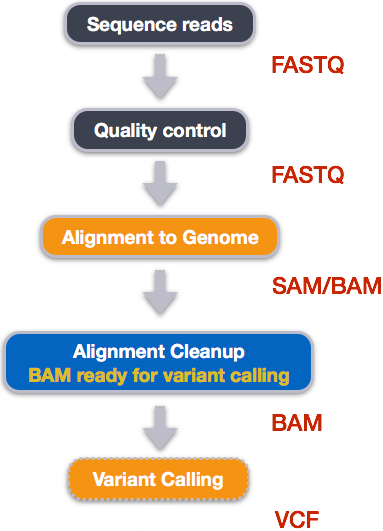


An example of the workflow we will be using for our variant calling analysis is provided below with a brief description of each step.



1. Quality control - Assessing quality using FastQC
2. Quality control - Trimming and/or filtering reads (if necessary)
3. Align reads to reference genome
4. Perform post-alignment clean-up
5. Variant calling

Our model is of a number of tools chained together. The output from one tool provides an input to the next, and so on.

This relies on some standards for data formats agreed within the community.  

The tools that are used to analyse data at different stages of the workflow are therefore built under the assumption that the data will be provided in a specific format.

## Part 1: Assessing quality of sequence reads

If you look at the filename we've downloaded, it has the file extension `fastq.gz`. The `.gz` means that it's a compressed file. We can uncompress it and take a look at the format.

In [ ]:
!gzip -dk SRR2589044_1.fastq.gz

|Line |	Description |
|-----|-------------|
|1|	Always begins with ‘@’ and then information about the read|
|2|	The actual DNA sequence|
|3|	Always begins with a ‘+’ and sometimes the same info in line 1|
|4|	Has a string of characters which represent the quality scores; must have same number of characters as line 2|

Take a look at the first four lines of one of these files.

In [ ]:
! ls -l

In [ ]:
! head -n 4 SRR2589044_1.fastq

If we knew what we were doing, we could compare line 2 and line 4 to understand read quality.

We're not going to do that! We'll use `fastqc` to do that for us.

FastQC can accept multiple file names as input, and on both zipped and unzipped files, so we can use the *.fastq* wildcard to run FastQC on all of the FASTQ files in this directory.

In [ ]:
! fastqc *.fastq* 

All the outputs are in `html` files so we need to put these somewhere else for later analysis.

We will:
* make a directory `results`
* inside that make a directory `fastqc_untrimmed_reads`

What files do we have?

In [ ]:
!ls -l

In [ ]:
!pwd

In [ ]:
! mkdir -p ../../results/fastqc_untrimmed_reads

We need to move the `zip` and `html` files

In [ ]:
! mv *.zip ../../results/fastqc_untrimmed_reads
! mv *.html ../../results/fastqc_untrimmed_reads

As there isn't an easy way to view these HTML files directly in the browser, we'll have to pop out the file browser to the left of the page, download to our desktop and then open up in our local browser.

Assessing read quality is beyond the scope of this tutorial and is very much problem dependent. You at least have access to the quality reports to make decisions on.

## Part 2: Cleaning Reads

Fully assessing read quality is a bit beyong the scope of this afternoon, so we're now going to use a program called Trimmomatic to filter poor quality reads and trim poor quality bases from our samples.

We can run trimmomatic as either `TrimmomaticPE` or `TrimmomaticSE` for either paired or single ended reads in this notebook, but when we move over to ARC the command are `trimmomatic PE` and `trimmomatic SE`.

We can see some of the options:

In [ ]:
! TrimmomaticPE

For example, you can specify threads to indicate the number of processors on your computer that you want Trimmomatic to use. In most cases using multiple threads (processors) can help to run the trimming faster. 

These flags are not necessary, but they can give you more control over the command. 

The flags are followed by positional arguments, meaning the order in which you specify them is important. In paired end mode, Trimmomatic expects the two input files, and then the names of the output files. These files are described below. While, in single end mode, Trimmomatic will expect 1 file as input, after which you can enter the optional settings and lastly the name of the output file.

|option	|meaning|
|-------|-------|
|\<inputFile1>|	Input reads to be trimmed. Typically the file name will contain an _1 or _R1 in the name.|
|\<inputFile2>|	Input reads to be trimmed. Typically the file name will contain an _2 or _R2 in the name.|
|\<outputFile1P>|	Output file that contains surviving pairs from the _1 file.|
|\<outputFile1U>|	Output file that contains orphaned reads from the _1 file.|
|\<outputFile2P>|	Output file that contains surviving pairs from the _2 file.|
|\<outputFile2U>|	Output file that contains orphaned reads from the _2 file.|

The last thing trimmomatic expects to see is the trimming parameters:

|step	|meaning|
|-----|-------|
|ILLUMINACLIP|	Perform adapter removal.|
|SLIDINGWINDOW|	Perform sliding window trimming, cutting once the average quality within the window falls below a threshold.|
|LEADING|	Cut bases off the start of a read, if below a threshold quality.|
|TRAILING|	Cut bases off the end of a read, if below a threshold quality.|
|CROP|	Cut the read to a specified length.|
|HEADCROP|	Cut the specified number of bases from the start of the read.|
|MINLEN|	Drop an entire read if it is below a specified length.|
|TOPHRED33|	Convert quality scores to Phred-33.|
|TOPHRED64|	Convert quality scores to Phred-64.|

We will use only a few of these options and trimming steps in our analysis. It is important to understand the steps you are using to clean your data. For more information about the Trimmomatic arguments and options, see the Trimmomatic manual.

We'll now run Trimmomatic on our data, making sure we get hold of the Nextera adapter file first:

In [ ]:
! wget https://raw.githubusercontent.com/timflutre/trimmomatic/master/adapters/NexteraPE-PE.fa

In [ ]:
!ls

In [ ]:
!pwd

We will also use a sliding window of size 4 that will remove bases if their phred score is below 20 (like in our example above). We will also discard any reads that do not have at least 25 bases remaining after this trimming step. This command will take a few minutes to run.

In [ ]:
!TrimmomaticPE  SRR2589044_1.fastq SRR2589044_2.fastq.gz \
                SRR2589044_1.trim.fastq.gz SRR2589044_1un.trim.fastq.gz \
                SRR2589044_2.trim.fastq.gz SRR2589044_2un.trim.fastq.gz \
                SLIDINGWINDOW:4:20 MINLEN:25 ILLUMINACLIP:NexteraPE-PE.fa:2:40:15 

In [ ]:
!ls -l -h SRR2589044*

In [ ]:
# As we unzipped that file earlier, let's zip it up again
!gzip SRR2589044_1.fastq

In [ ]:
!ls -l

We've done one file!

But we have 4 others. The good news is that we can use a **loop** to run through all five files.

Let's write a script file to do this:

In [ ]:
%%writefile run_trims.sh
for infile in *_1.fastq.gz
do
   base=$(basename ${infile} _1.fastq.gz)
   TrimmomaticPE ${infile} ${base}_2.fastq.gz \
                ${base}_1.trim.fastq.gz ${base}_1un.trim.fastq.gz \
                ${base}_2.trim.fastq.gz ${base}_2un.trim.fastq.gz \
                SLIDINGWINDOW:4:20 MINLEN:25 ILLUMINACLIP:NexteraPE-PE.fa:2:40:15 
done

In [ ]:
!ls -l *.sh

In [ ]:
# We need to make this file runnable:
! chmod u+x run_trims.sh

In [ ]:
!ls -l *.sh

In [ ]:
# So now we can run it
! ./run_trims.sh

We’ve now completed the trimming and filtering steps of our quality control process. 

Before we move on, let’s move our trimmed FASTQ files to a new subdirectory within our `data/` directory.

In [ ]:
! mkdir -p /content/data/trimmed_fastq
! mv *.trim* /content/data/trimmed_fastq

Confirm the files are moved by checking in the file viewer to the left.

## Part 3: Alignment to a reference genome

We mentioned before that we are working with files from a long-term evolution study of an E. coli population (designated Ara-3). 

Now that we have looked at our data to make sure that it is high quality, and removed low-quality base calls, we can perform variant calling to see how the population changed over time. 

We care how this population changed relative to the original population, E. coli strain REL606. 

Therefore, we will align each of our samples to the E. coli REL606 reference genome, and see what differences exist in our reads versus the genome.



We perform read alignment or mapping to determine where in the genome our reads originated from. 

There are a number of tools to choose from and, while there is no gold standard, there are some tools that are better suited for particular NGS analyses. 

We will be using the Burrows Wheeler Aligner (BWA), which is a software package for mapping low-divergent sequences against a large reference genome.

The alignment process consists of two steps:

* Indexing the reference genome
* Aligning the reads to the reference genome

In [ ]:
# First get the reference genome for E. coli REL606
! mkdir -p /content/data/ref_genome
! curl -L -o /content/data/ref_genome/ecoli_rel606.fasta.gz ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/017/985/GCA_000017985.1_ASM1798v1/GCA_000017985.1_ASM1798v1_genomic.fna.gz
! gunzip /content/data/ref_genome/ecoli_rel606.fasta.gz

To make life a bit easier, we'll also download a set of trimmed FASTQ files to work with. These are small subsets of our real trimmed data, and will enable us to run our variant calling workflow quite quickly.

In [ ]:
!curl -L -o sub.tar.gz https://ndownloader.figshare.com/files/14418248
!tar xvf sub.tar.gz
!mv sub/ /content/data/trimmed_fastq_small

### Part 3.1: Index the reference genome

Our first step is to index the reference genome for use by BWA. Indexing allows the aligner to quickly find potential alignment sites for query sequences in a genome, which saves time during alignment. 

Indexing the reference only has to be run once. The only reason you would want to create a new index is if you are working with a different reference genome or you are using a different tool for alignment.

In [ ]:
!bwa index /content/data/ref_genome/ecoli_rel606.fasta

### Part 3.2: Align reads to the reference genome

The alignment process consists of choosing an appropriate reference genome to map our reads against and then deciding on an aligner. We will use the BWA-MEM algorithm, which is the latest and is generally recommended for high-quality queries as it is faster and more accurate.

We’re going to start by aligning the reads from just one of the samples in our dataset (SRR2584866). Later, we’ll be iterating this whole process on all of our sample files.

In [ ]:
# make a directory to receive the SAM files
! mkdir -p /content/results/sam

In [ ]:
! bwa mem /content/data/ref_genome/ecoli_rel606.fasta /content/data/trimmed_fastq_small/SRR2584866_1.trim.sub.fastq /content/data/trimmed_fastq_small/SRR2584866_2.trim.sub.fastq > /content/results/sam/SRR2584866.aligned.sam

We will convert the `SAM` file to `BAM` format using the `samtools` program with the `view` command and tell this command that the input is in `SAM` format `(-S)` and to output `BAM` format `(-b)`:

In [ ]:
# create a bam output directory
! mkdir -p /content/results/bam

In [ ]:
! samtools view -S -b /content/results/sam/SRR2584866.aligned.sam > /content/results/bam/SRR2584866.aligned.bam

### Part 3.3: Sort BAM file by coordinates

Next we sort the BAM file using the `sort` command from `samtools`. `-o` tells the command where to write the output.

In [ ]:
!samtools sort -o /content/results/bam/SRR2584866.aligned.sorted.bam /content/results/bam/SRR2584866.aligned.bam 

## Part 4: Variant Calling

A variant call is a conclusion that there is a nucleotide difference vs. some reference at a given position in an individual genome or transcriptome, often referred to as a Single Nucleotide Polymorphism (SNP). 

The call is usually accompanied by an estimate of variant frequency and some measure of confidence. Similar to other steps in this workflow, there are a number of tools available for variant calling. In this workshop we will be using `bcftools`, but there are a few things we need to do before actually calling the variants.

### Part 4.1: Calculate the read coverage of positions in the genome

Do the first pass on variant calling by counting read coverage with `bcftools`. 

We will use the command `mpileup`. The flag `-O b` tells `bcftools` to generate a bcf format output file, -o specifies where to write the output file, and -f flags the path to the reference genome:

In [ ]:
# make a bcf directory
! mkdir -p /content/results/bcf

In [ ]:
!bcftools mpileup -O b -o /content/results/bcf/SRR2584866_raw.bcf \
-f /content/data/ref_genome/ecoli_rel606.fasta /content/results/bam/SRR2584866.aligned.sorted.bam 

### Part 4.2: Detect the single nucleotide polymorphisms (SNPs)

Identify SNPs using bcftools call. 

We have to specify ploidy with the flag `--ploidy`, which is one for the haploid E. coli. `-m` allows for multiallelic and rare-variant calling, `-v` tells the program to output variant sites only (not every site in the genome), and `-o` specifies where to write the output file:

In [ ]:
!bcftools call --ploidy 1 -m -v -o /content/results/bcf/SRR2584866_variants.vcf /content/results/bcf/SRR2584866_raw.bcf 

### Part 4.3: Filter and report the SNP variants in variant calling format (VCF)

Filter the SNPs for the final output in VCF format, using `vcfutils.pl`:

In [ ]:
# make the vcf directory to receive the results
! mkdir -p /content/results/vcf

In [ ]:
!vcfutils.pl varFilter /content/results/bcf/SRR2584866_variants.vcf  > /content/results/vcf/SRR2584866_final_variants.vcf